# Determining the cost of cars

Необходимо построить модель для определения стоимости автомобиля.



## Data preparation

In [1]:
import pandas as pd
import time
import pickle

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score 
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('datasets/autos.csv')

In [3]:
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [4]:
df.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


In [5]:
df=df.drop(['DateCrawled', 'DateCreated','NumberOfPictures','PostalCode','LastSeen','RegistrationMonth'], axis=1)
categorical_columns = df.select_dtypes(include=['object']).columns
df[categorical_columns] = df[categorical_columns].fillna('unknown')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             354369 non-null  int64 
 1   VehicleType       354369 non-null  object
 2   RegistrationYear  354369 non-null  int64 
 3   Gearbox           354369 non-null  object
 4   Power             354369 non-null  int64 
 5   Model             354369 non-null  object
 6   Kilometer         354369 non-null  int64 
 7   FuelType          354369 non-null  object
 8   Brand             354369 non-null  object
 9   Repaired          354369 non-null  object
dtypes: int64(4), object(6)
memory usage: 27.0+ MB


удалены столбцы с датами (DateCrawled, DateCreated, LastSeen, RegistrationMonth)
удален столбец с количеством фотографий автомобиля (NumberOfPictures) ,так как для всех объектов он равен нулю.
удален столбец с почтовым индексом владельца анкеты (PostalCode), так как он может приводить к переобучению модели.

Пропущенные значения в категориальных признаках заменены на значене неизвестно(unknown).

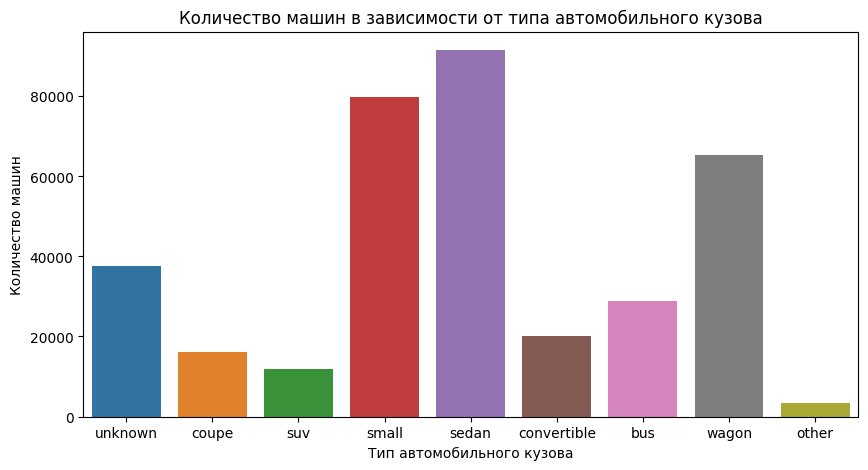

In [6]:
plt.figure(figsize=(10,5))
plt.title('Количество машин в зависимости от типа автомобильного кузова')
sns.countplot(x="VehicleType", data=df)
plt.ylabel('Количество машин')
plt.xlabel('Тип автомобильного кузова');

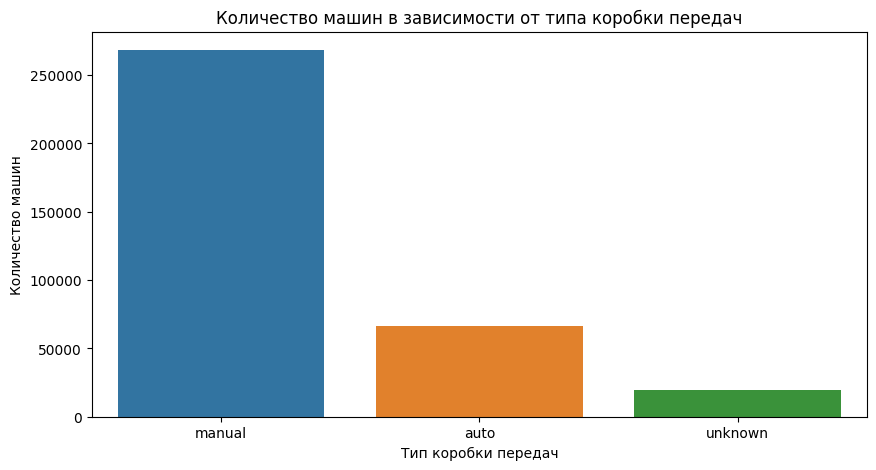

In [7]:
plt.figure(figsize=(10,5))
plt.title('Количество машин в зависимости от типа коробки передач')
sns.countplot(x="Gearbox", data=df)
plt.ylabel('Количество машин')
plt.xlabel('Тип коробки передач');

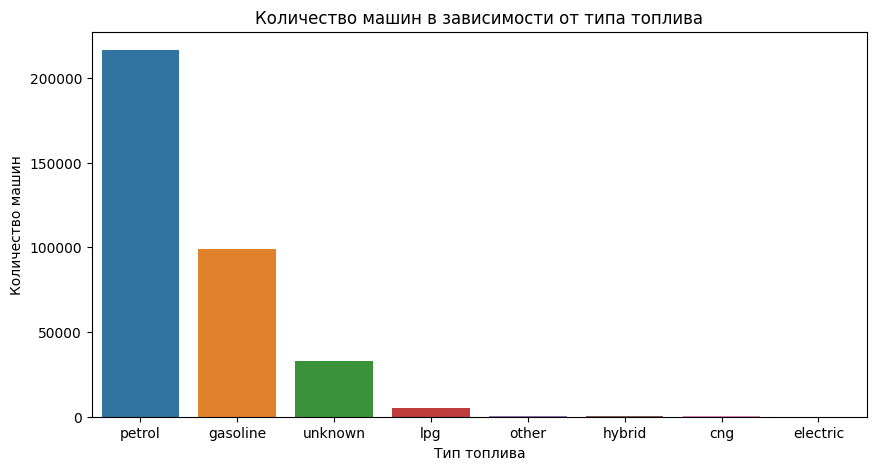

In [8]:
plt.figure(figsize=(10,5))
plt.title('Количество машин в зависимости от типа топлива')
sns.countplot(x="FuelType", data=df)
plt.ylabel('Количество машин')
plt.xlabel('Тип топлива');

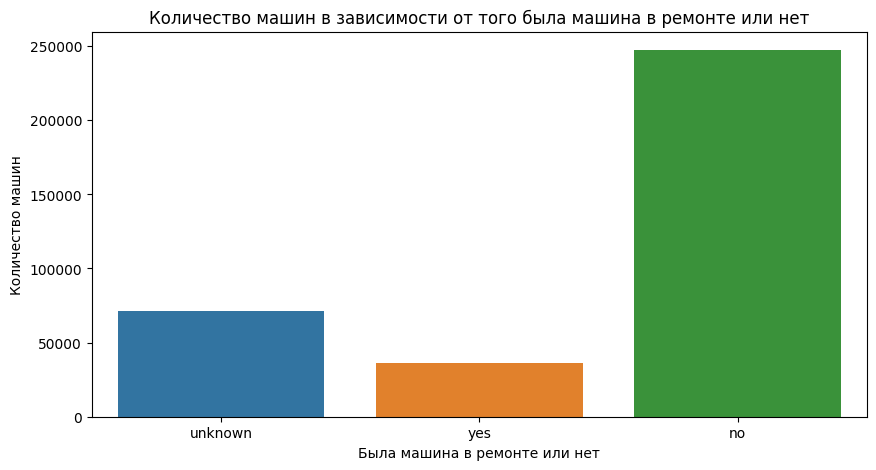

In [9]:
plt.figure(figsize=(10,5))
plt.title('Количество машин в зависимости от того была машина в ремонте или нет')
sns.countplot(x="Repaired", data=df)
plt.ylabel('Количество машин')
plt.xlabel('Была машина в ремонте или нет');

In [10]:
df['RegistrationYear'] = df['RegistrationYear'].astype('int')
df['Kilometer'] = df['Kilometer'].astype('int')
df['Power'] = df['Power'].astype('int')
df = df.reset_index(drop=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             354369 non-null  int64 
 1   VehicleType       354369 non-null  object
 2   RegistrationYear  354369 non-null  int64 
 3   Gearbox           354369 non-null  object
 4   Power             354369 non-null  int64 
 5   Model             354369 non-null  object
 6   Kilometer         354369 non-null  int64 
 7   FuelType          354369 non-null  object
 8   Brand             354369 non-null  object
 9   Repaired          354369 non-null  object
dtypes: int64(4), object(6)
memory usage: 27.0+ MB


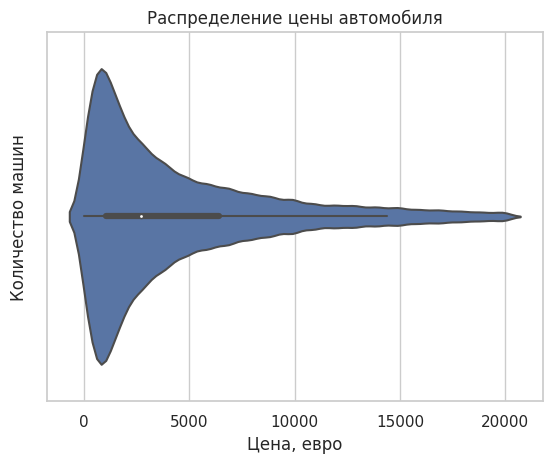

In [11]:
sns.set_theme(style="whitegrid")
plt.title('Распределение цены автомобиля')
sns.violinplot(x=df["Price"])
plt.ylabel('Количество машин')
plt.xlabel('Цена, евро');

хозяин машины  может отдать её бесплатно, поэтому Price равным нулю не будем считать за аномалию.

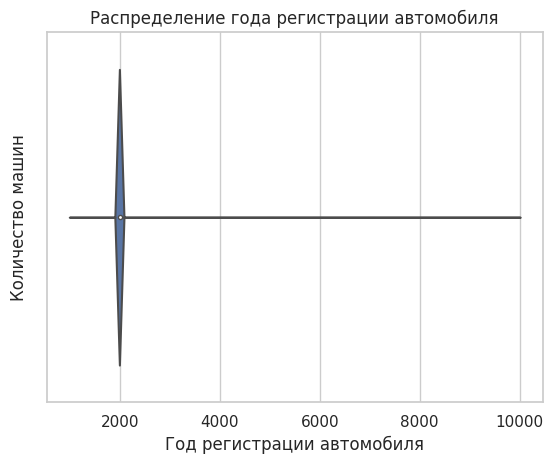

In [12]:
sns.set_theme(style="whitegrid")
plt.title('Распределение года регистрации автомобиля')
sns.violinplot(x=df["RegistrationYear"])
plt.ylabel('Количество машин')
plt.xlabel('Год регистрации автомобиля');

Машины выпущенные ранее 1970 года не учитываем.

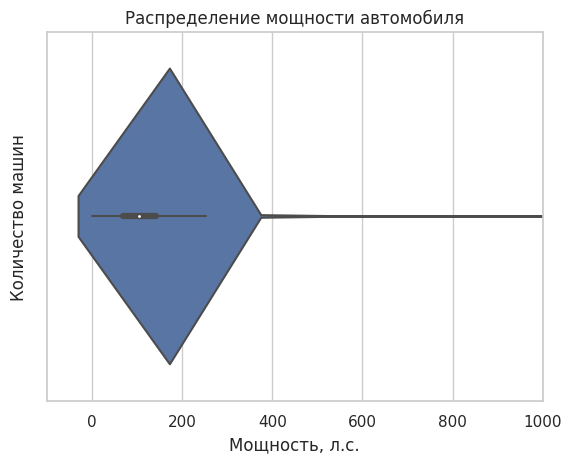

In [13]:
sns.set_theme(style="whitegrid")
plt.title('Распределение мощности автомобиля')
sns.violinplot(x=df["Power"])
plt.ylabel('Количество машин')
plt.xlabel('Мощность, л.с.')
plt.xlim(-100,1000);

Мощность равную нулю и больше 263 считаем за аномалии.

In [14]:
data = df.query('0<Power<=262.5 and  1970<=RegistrationYear and Power<263 and Power!=0').reset_index(drop=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306727 entries, 0 to 306726
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             306727 non-null  int64 
 1   VehicleType       306727 non-null  object
 2   RegistrationYear  306727 non-null  int64 
 3   Gearbox           306727 non-null  object
 4   Power             306727 non-null  int64 
 5   Model             306727 non-null  object
 6   Kilometer         306727 non-null  int64 
 7   FuelType          306727 non-null  object
 8   Brand             306727 non-null  object
 9   Repaired          306727 non-null  object
dtypes: int64(4), object(6)
memory usage: 23.4+ MB


<b> Вывод: </b> 

Была проведена предобработка данных:
    <ul>
    <li>удалены столбцы с датами (DateCrawled, DateCreated, LastSeen, RegistrationMonth)</li>
    <li>удален столбец с количеством фотографий автомобиля (NumberOfPictures) ,так как для всех объектов он равен нулю.</li>  <li>удален столбец с почтовым индексом владельца анкеты (PostalCode), так как он может приводить к переобучению модели</li>
        <li> пропущенные значения заменены на значение unknown</li>
        <li>удалены значения unknown из целевого признака (Price)</li>
        <li>изменен тип данных строк на целое число в столбцах RegistrationYear, Kilometer, Price, Power</li>
    <li> Удалены аномалии из количественных признаков</li>
</ul>


## Training

In [15]:
X = data.drop(['Price'],axis=1)
y = data['Price']

In [16]:
categorical_columns

Index(['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'Repaired'], dtype='object')

In [17]:
numeric_columns = X.select_dtypes(exclude=['object']).columns
numeric_columns

Index(['RegistrationYear', 'Power', 'Kilometer'], dtype='object')

Преобразуем категориальные признаки в численные с помощью One-Hot Encoding.

In [18]:
ohe = OneHotEncoder(sparse=False, handle_unknown='ignore', drop='first')

In [19]:
encoded_data = ohe.fit_transform(X[categorical_columns])

In [20]:
X_new = np.concatenate((encoded_data, X[numeric_columns].values), axis=1)

Разделим выборка на обучающую и тестовую.

In [21]:
X_train , X_test , y_train , y_test = train_test_split(X_new, y , test_size = 0.25 , random_state = 12345)

In [22]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Обучим LinearRegression, DecisionTree, LightGBM, CatBoost и оценим результат на тестовой выборке

In [23]:
result = {}
rmse ={}
mae= {}
r2 ={}

In [24]:
start_time = time.time()
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)
pred = model_lr.predict(X_test)
mse = mean_squared_error(y_test, pred)
rmse['LinearRegression'] = mse**0.5
mae['LinearRegression'] = mean_absolute_error(y_test, pred)
r2['LinearRegression'] = r2_score(y_test, pred)
result['LinearRegression'] = time.time() - start_time
print("time_LinearRegression :",result['LinearRegression'])
print('RMSE_LinearRegression =',rmse['LinearRegression'])
print('MAE_LinearRegression =',mae['LinearRegression'])
print('R2_LinearRegression =',r2['LinearRegression'])

time_LinearRegression : 9.230064868927002
RMSE_LinearRegression = 2774.411162685697
MAE_LinearRegression = 1979.3772560436184
R2_LinearRegression = 0.6111921539764026


In [25]:
start_time = time.time()
model_dtr = DecisionTreeRegressor(max_depth=19, min_samples_split=6,random_state=12345)
model_dtr.fit(X_train, y_train)
pred = model_dtr.predict(X_test)
mse = mean_squared_error(y_test, pred)
rmse['DecisionTreeRegressor'] = mse**0.5
mae['DecisionTreeRegressor'] = mean_absolute_error(y_test, pred)
r2['DecisionTreeRegressor'] = r2_score(y_test, pred)
result['DecisionTreeRegressor'] = time.time() - start_time
print("time_DecisionTreeRegressor :",result['DecisionTreeRegressor'])
print('RMSE_DecisionTreeRegressor =',rmse['DecisionTreeRegressor'])
print('MAE_DecisionTreeRegressor =',mae['DecisionTreeRegressor'])
print('R2_DecisionTreeRegressor =',r2['DecisionTreeRegressor'])

time_DecisionTreeRegressor : 8.981865882873535
RMSE_DecisionTreeRegressor = 1826.0885755861832
MAE_DecisionTreeRegressor = 1101.3790440184998
R2_DecisionTreeRegressor = 0.83156317252931


In [29]:
start_time = time.time()
model_lgbm = LGBMRegressor(random_state=12345, verbosity=-1)
model_lgbm.fit(X_train, y_train)
pred = model_lgbm.predict(X_test)
mse = mean_squared_error(y_test, pred)
rmse['LGBMRegressor'] = mse**0.5
mae['LGBMRegressor'] = mean_absolute_error(y_test, pred)
r2['LGBMRegressor'] = r2_score(y_test, pred)
result['LGBMRegressor'] = time.time() - start_time
print("time_LGBMRegressor :",result['LGBMRegressor'])
print('RMSE_LGBMRegressor =',rmse['LGBMRegressor'])
print('MAE_LGBMRegressor =',mae['LGBMRegressor'])
print('R2_LGBMRegressor =',r2['LGBMRegressor'])

time_LGBMRegressor : 3.680300712585449
RMSE_LGBMRegressor = 1704.13205885345
MAE_LGBMRegressor = 1073.0869327145112
R2_LGBMRegressor = 0.8533102166115647


In [27]:
start_time = time.time()
model_cb = CatBoostRegressor(random_state=12345, verbose=False)
model_cb.fit(X_train, y_train)
pred = model_cb.predict(X_test)
mse = mean_squared_error(y_test, pred)
rmse['CatBoostRegressor'] = mse**0.5
mae['CatBoostRegressor'] = mean_absolute_error(y_test, pred)
r2['CatBoostRegressor'] = r2_score(y_test, pred)
result['CatBoostRegressor'] = time.time() - start_time
print("time_CatBoostRegressor :",result['CatBoostRegressor'])
print('RMSE_CatBoostRegressor =',rmse['CatBoostRegressor'])
print('MAE_CatBoostRegressor =',mae['CatBoostRegressor'])
print('R2_CatBoostRegressor =',r2['CatBoostRegressor'])

time_CatBoostRegressor : 41.06583595275879
RMSE_CatBoostRegressor = 1616.064499116791
MAE_CatBoostRegressor = 1005.2020241564757
R2_CatBoostRegressor = 0.868079966180082


## Evaluation of models

In [28]:
data_result = pd.DataFrame(data=[rmse,mae,r2,result], index=['rmse','mae','r2','time'])
data_result

,LinearRegression,DecisionTreeRegressor,LGBMRegressor,CatBoostRegressor
rmse,2774.411163,1826.088576,1704.132059,1616.064499
mae,1979.377256,1101.379044,1073.086933,1005.202024
r2,0.611192,0.831563,0.853310,0.868080
time,9.230065,8.981866,4.316628,41.065836


<b> Conclusion: </b> Лучшей моделью по метрикам CatBoostRegressor, по времени - LGBMRegressor. Оптимальной моделью является LGBMRegressor.

## Hyperparameter Tuning

Для модели LGBMRegressor проводиться настройка параметров

In [30]:
model = LGBMRegressor(random_state=12345, verbosity=-1)

param_grid = {
    'n_estimators': [100, 500, 1000],
    'learning_rate': [0.01, 0.1, 0.5],
    'max_depth': [5, 10, 15],
}
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=3,)

In [31]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=LGBMRegressor(random_state=12345, verbosity=-1),
             param_grid={'learning_rate': [0.01, 0.1, 0.5],
                         'max_depth': [5, 10, 15],
                         'n_estimators': [100, 500, 1000]},
             scoring='neg_mean_squared_error')

In [32]:
print("Лучшие параметры:", grid_search.best_params_)
print("Лучший результат (RMSE):", (-grid_search.best_score_)**0.5)

Лучшие параметры: {'learning_rate': 0.1, 'max_depth': 15, 'n_estimators': 1000}
Лучший результат (RMSE): 1607.9928769461617


In [42]:
start_time = time.time()
model_lgbm = LGBMRegressor(random_state=12345, learning_rate= 0.1, max_depth= 15, n_estimators= 1000, verbosity=-1)
model_lgbm.fit(X_train, y_train)
pred = model_lgbm.predict(X_test)
mse = mean_squared_error(y_test, pred)
rmse['LGBMRegressor'] = mse**0.5
mae['LGBMRegressor'] = mean_absolute_error(y_test, pred)
r2['LGBMRegressor'] = r2_score(y_test, pred)
result['LGBMRegressor'] = time.time() - start_time
print("time_LGBMRegressor :",result['LGBMRegressor'])
print('RMSE_LGBMRegressor =',rmse['LGBMRegressor'])
print('MAE_LGBMRegressor =',mae['LGBMRegressor'])
print('R2_LGBMRegressor =',r2['LGBMRegressor'])

time_LGBMRegressor : 8.630115270614624
RMSE_LGBMRegressor = 1579.0584635264001
MAE_LGBMRegressor = 974.3769527408574
R2_LGBMRegressor = 0.8740524297935046


Сохраняем модель

In [43]:
model_data = {
    'model': model_lgbm,
    "ohe": ohe, 
    "scaler": scaler,
    }
pickle.dump(model_data, open('data/model.pkl', 'wb'))